In [19]:
import os
os.environ['OMP_NUM_THREADS'] = '4'
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import openai
#openai.api_key = os.environ['OPENAI_API_KEY']




openai.api_base = os.environ.get("OPENAI_API_BASE", "https://api.openai.com/v1")
from data.serialize import SerializerSettings
from models.utils import grid_iter
from models.promptcast import get_promptcast_predictions_data
from models.darts import get_arima_predictions_data
from models.llmtime import get_llmtime_predictions_data
from data.small_context import get_datasets
from models.validation_likelihood_tuning import get_autotuned_predictions_data
import logging
import pickle

def plot_preds(train, test, pred_dict, model_name, show_samples=False):
    pred = pred_dict['median']
    pred = pd.Series(pred, index=test.index)
    plt.figure(figsize=(8, 6), dpi=100)
    plt.plot(train)
    plt.plot(test, label='Truth', color='black')
    plt.plot(pred, label=model_name, color='purple')
    # shade 90% confidence interval
    samples = pred_dict['samples']
    lower = np.quantile(samples, 0.05, axis=0)
    upper = np.quantile(samples, 0.95, axis=0)
    plt.fill_between(pred.index, lower, upper, alpha=0.3, color='purple')
    if show_samples:
        samples = pred_dict['samples']
        # convert df to numpy array
        samples = samples.values if isinstance(samples, pd.DataFrame) else samples
        for i in range(min(10, samples.shape[0])):
            plt.plot(pred.index, samples[i], color='purple', alpha=0.3, linewidth=1)
    plt.legend(loc='upper left')
    if 'NLL/D' in pred_dict:
        nll = pred_dict['NLL/D']
        if nll is not None:
            plt.text(0.03, 0.85, f'NLL/D: {nll:.2f}', transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=0.5))
    plt.show()



gpt4_hypers = dict(
    alpha=0.3,
    basic=True,
    temp=1.0,
    top_p=0.8,
    settings=SerializerSettings(base=10, prec=3, signed=True, time_sep=', ', bit_sep='', minus_sign='-')
)

gpt3_hypers = dict(
    temp=0.7,
    alpha=0.95,
    beta=0.3,
    basic=False,
    settings=SerializerSettings(base=10, prec=3, signed=True, half_bin_correction=True)
)


promptcast_hypers = dict(
    temp=0.7,
    settings=SerializerSettings(base=10, prec=0, signed=True, 
                                time_sep=', ',
                                bit_sep='',
                                plus_sign='',
                                minus_sign='-',
                                half_bin_correction=False,
                                decimal_point='')
)

arima_hypers = dict(p=[12,30], d=[1,2], q=[0])

model_hypers = {
    #'LLMTime GPT-3.5': {'model': 'gpt-3.5-turbo-instruct', **gpt3_hypers},
    'LLMTime GPT-4': {'model': 'gpt-4', **gpt4_hypers},
    #'LLMTime GPT-3': {'model': 'text-davinci-003', **gpt3_hypers},
    #'PromptCast GPT-3': {'model': 'text-davinci-003', **promptcast_hypers},
    'ARIMA': arima_hypers,
    
}

model_predict_fns = {

    #'LLMTime GPT-3': get_llmtime_predictions_data,
    #'LLMTime GPT-3.5': get_llmtime_predictions_data,
    'LLMTime GPT-4': get_llmtime_predictions_data,
    #'PromptCast GPT-3': get_promptcast_predictions_data,
    'ARIMA': get_arima_predictions_data,
}

model_names = list(model_predict_fns.keys())



In [20]:
hypers = list(grid_iter(model_hypers['LLMTime GPT-4']))

In [202]:
highsample = np.genfromtxt('./synthetic_data/highsample4.csv', delimiter=',')
highsample_train = highsample[0:50]
highsample_test = highsample[50:100]

In [22]:
highsample_train[:,1].shape

(50,)

In [23]:
num_samples = 10
highsample_gpt = get_autotuned_predictions_data(highsample_train[:,1], highsample_test[:,1], hypers, num_samples, model_predict_fns['LLMTime GPT-4'], verbose=False, parallel=False)


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf



100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.48s/it]


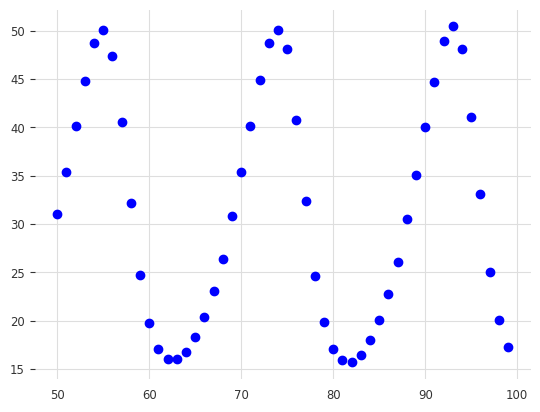

In [25]:
plt.plot(highsample_gpt['median'],'bo')

In [28]:
highsample_posterior_gpt = highsample_gpt['samples'].to_csv("./raunak_results/highsample_posterior_gpt.csv")
highsample_median_gpt = highsample_gpt['median'].to_csv("./raunak_results/highsample_median_gpt.csv")


In [29]:
highsample_arima = get_autotuned_predictions_data(highsample_train[:,1], highsample_test[:,1], hypers, num_samples, model_predict_fns['ARIMA'], verbose=False, parallel=False)


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

In [30]:
highsample_posterior_arima = highsample_arima['samples'].to_csv("./raunak_results/highsample_posterior_arima.csv")
highsample_median_arima = highsample_arima['median'].to_csv("./raunak_results/highsample_median_arima.csv")


UsageError: Line magic function `%plt.legend(["actual` not found.


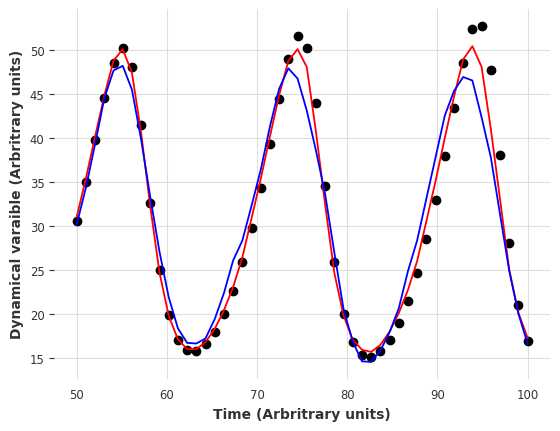

In [43]:
plt.plot(np.linspace(50,100,50), highsample_test[:,1],'ko')
plt.plot(np.linspace(50,100,50),highsample_gpt['median'],'r')
plt.plot(np.linspace(50,100,50),highsample_arima['median'],'b')

plt.xlabel('Time (Arbritrary units)')
plt.ylabel('Dynamical varaible (Arbritrary units)')
%plt.legend(["actual dynamics", "GPT-4 predicted dynamics","ARIMA predicted dynamics"], loc="upper right")


In [44]:
highsample2_gpt = get_autotuned_predictions_data(highsample_train[:,2], highsample_test[:,2], hypers, num_samples, model_predict_fns['LLMTime GPT-4'], verbose=False, parallel=False)


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf



100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.99s/it]

In [45]:
highsample2_posterior_gpt = highsample2_gpt['samples'].to_csv("./raunak_results/highsample2_posterior_gpt.csv")
highsample2_median_gpt = highsample2_gpt['median'].to_csv("./raunak_results/highsample2_median_gpt.csv")


In [46]:
highsample2_arima = get_autotuned_predictions_data(highsample_train[:,2], highsample_test[:,2], hypers, num_samples, model_predict_fns['ARIMA'], verbose=False, parallel=False)


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Users/rdey33/miniconda3/envs/llmtime/lib/python3.9/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("

In [47]:
highsample2_posterior_arima = highsample_arima['samples'].to_csv("./raunak_results/highsample2_posterior_arima.csv")
highsample2_median_arima = highsample_arima['median'].to_csv("./raunak_results/highsample2_median_arima.csv")


Text(0, 0.5, 'Dynamical varaible (Arbritrary units)')

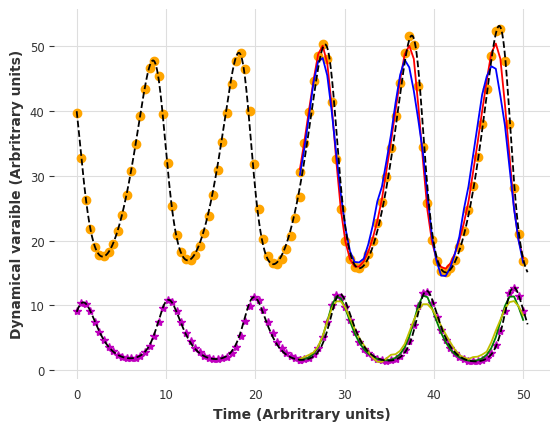

In [125]:
plt.plot(np.linspace(0, 25, 50), highsample_train[0:50, 1], 'o', color='orange')
plt.plot(np.linspace(25,50,50), highsample_test[:, 1], 'o', color='orange')
plt.plot(np.linspace(25,50,50),highsample_gpt['median'],'r')
plt.plot(np.linspace(25,50,50),highsample_arima['median'],'b')
plt.plot(np.linspace(0,101/2,2000),pred[0:2000],'--k')

plt.plot(np.linspace(0, 50/2, 50), highsample_train[0:50,2], '*', color='m')
plt.plot(np.linspace(50/2,100/2,50), highsample_test[:,2], '*', color='m')
plt.plot(np.linspace(50/2,100/2,50),highsample2_gpt['median'],'g')
plt.plot(np.linspace(50/2,100/2,50),highsample2_arima['median'],'y')
plt.plot(np.linspace(0,101/2,2000),prey[0:2000],'--k')

#plt.xlim([50 , 190])
plt.xlabel('Time (Arbritrary units)')
plt.ylabel('Dynamical varaible (Arbritrary units)')
#plt.legend(["actual predator dynamics (samples)", "GPT-4 predicted predator dynamics","ARIMA predicted predator dynamics","actual prey dynamics (samples)", "GPT-4 predicted prey dynamics","ARIMA predicted prey dynamics"], loc="right")
#plt.savefig("lokta_volterra_high.png")


In [ ]:
plt.plot(np.linspace(50/2,100/2,50),highsample2_arima['median'],'y')

In [123]:
lowsample = np.genfromtxt('./synthetic_data/lowsample5.csv', delimiter=',')
lowsample_train = lowsample[0:50]
lowsample_test = lowsample[50:100]

lowsample_gpt = get_autotuned_predictions_data(lowsample_train[:,1], lowsample_test[:,1], hypers, num_samples, model_predict_fns['LLMTime GPT-4'], verbose=False, parallel=False)
lowsample_posterior_gpt = lowsample_gpt['samples'].to_csv("./raunak_results/lowsample_posterior_gpt.csv")
lowsample_median_gpt = lowsample_gpt['median'].to_csv("./raunak_results/lowsample_median_gpt.csv")

lowsample_arima = get_autotuned_predictions_data(lowsample_train[:,1], lowsample_test[:,1], hypers, num_samples, model_predict_fns['ARIMA'], verbose=False, parallel=False)
lowsample_posterior_arima = lowsample_arima['samples'].to_csv("./raunak_results/lowsample_posterior_arima.csv")
lowsample_median_arima = lowsample_arima['median'].to_csv("./raunak_results/lowsample_median_arima.csv")


lowsample2_gpt = get_autotuned_predictions_data(lowsample_train[:,2], lowsample_test[:,2], hypers, num_samples, model_predict_fns['LLMTime GPT-4'], verbose=False, parallel=False)
lowsample2_posterior_gpt = lowsample2_gpt['samples'].to_csv("./raunak_results/lowsample2_posterior_gpt.csv")
lowsample2_median_gpt = lowsample2_gpt['median'].to_csv("./raunak_results/lowsample2_median_gpt.csv")

lowsample2_arima = get_autotuned_predictions_data(lowsample_train[:,2], lowsample_test[:,2], hypers, num_samples, model_predict_fns['ARIMA'], verbose=False, parallel=False)
lowsample2_posterior_arima = lowsample2_arima['samples'].to_csv("./raunak_results/lowsample2_posterior_arima.csv")
lowsample2_median_arima = lowsample2_arima['median'].to_csv("./raunak_results/lowsample2_median_arima.csv")



Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


  0%|                                                     | 0/1 [00:00<?, ?it/s]

KeyboardInterrupt: 

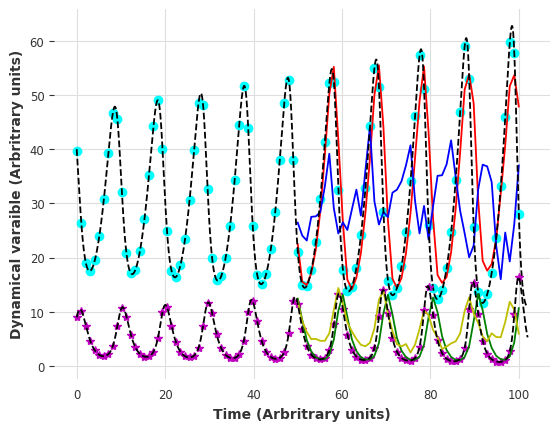

In [116]:
#plt.plot(np.linspace(0,50,50), lowsample_train[:,1],'ko')
plt.plot(np.linspace(0, 49, 49), lowsample_train[1:50, 1], 'o', color='orange')
plt.plot(np.linspace(50,100,50), lowsample_test[:, 1], 'o', color='orange')
plt.plot(np.linspace(50,100,50),lowsample_gpt['median'],'r')
plt.plot(np.linspace(50,100,50),lowsample_arima['median'],'b')
plt.plot(np.linspace(0,102,4000),pred,'--k')

plt.plot(np.linspace(0, 49, 49), lowsample_train[1:50,2], '*', color='m')
plt.plot(np.linspace(50,100,50), lowsample_test[:,2], '*', color='m')
plt.plot(np.linspace(50,100,50), lowsample2_gpt['median'],'g')
plt.plot(np.linspace(50,100,50),lowsample2_arima['median'],'y')
plt.plot(np.linspace(0,102,4000),prey,'--k')

#plt.xlim([50 , 190])
plt.xlabel('Time (Arbritrary units)')
plt.ylabel('Dynamical varaible (Arbritrary units)')
#plt.legend(["actual predator dynamics", "GPT-4 predicted predator dynamics","ARIMA predicted predator dynamics","actual prey dynamics", "GPT-4 predicted prey dynamics","ARIMA predicted prey dynamics"], loc="right")
plt.savefig("lokta_volterra_low.png")


In [79]:
len(lowsample_train[1:50, 1])

49

In [199]:
import numpy as np
import matplotlib.pyplot as plt

def lotka_volterra(a, b, c, d, x0, y0, timesteps):
    """
    Simulate the Lotka-Volterra equations.

    Parameters:
    a: float, prey growth rate
    b: float, predation rate
    c: float, predator death rate
    d: float, predator reproduction rate
    x0: float, initial prey population
    y0: float, initial predator population
    timesteps: int, number of time steps

    Returns:
    x_values: numpy array, prey population over time
    y_values: numpy array, predator population over time
    """

    def dx_dt(x, y):
        return a * x - b * x * y

    def dy_dt(x, y):
        return -c * y + d * x * y

    dt = 0.01  # Time step size
    x_values = np.zeros(timesteps)
    y_values = np.zeros(timesteps)

    x_values[0] = x0
    y_values[0] = y0

    for i in range(1, timesteps):
        x = x_values[i - 1]
        y = y_values[i - 1]
        x_values[i] = x + dt * dx_dt(x, y)
        y_values[i] = y + dt * dy_dt(x, y)

    return x_values, y_values

# Example usage:
a = 1
b = 0.2
c = 3
d = 0.1
x0 = 40
y0 = 9
timesteps = 4000

pred, prey = lotka_volterra(a, b, c, d, x0, y0, timesteps)


In [96]:
len(pred)

4000

In [112]:
lowsample_train

array([[        nan,  0.        ,  1.        ],
       [ 0.        , 39.68      ,  9.09      ],
       [ 1.        , 26.34880519, 10.24748765],
       [ 2.        , 19.0341152 ,  7.48061954],
       [ 3.        , 17.57515665,  4.60852889],
       [ 4.        , 19.53895343,  2.87847104],
       [ 5.        , 24.01660892,  2.04789187],
       [ 6.        , 30.76669456,  1.82514915],
       [ 7.        , 39.23533064,  2.2110452 ],
       [ 8.        , 46.70663746,  3.73471962],
       [ 9.        , 45.47167648,  7.40063533],
       [10.        , 32.02545061, 10.7813259 ],
       [11.        , 20.83483801,  9.13983631],
       [12.        , 17.10738448,  5.76100001],
       [13.        , 17.7782116 ,  3.43605725],
       [14.        , 21.23591765,  2.23064786],
       [15.        , 27.09203786,  1.74591886],
       [16.        , 35.16657854,  1.80709569],
       [17.        , 44.22658172,  2.65049332],
       [18.        , 49.00148622,  5.2667141 ],
       [19.        , 40.06364703,  9.912

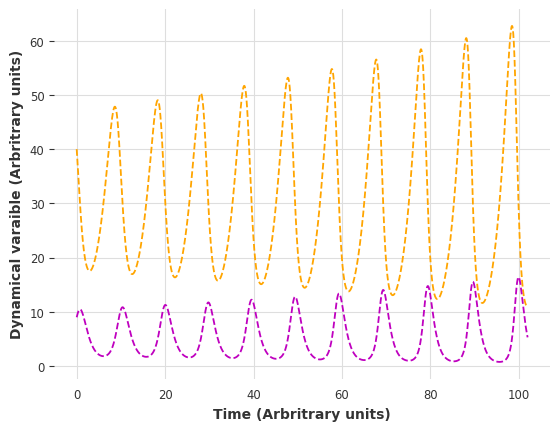

In [200]:
plt.plot(np.linspace(0,102,4000),pred,'--',color='orange')
plt.plot(np.linspace(0,102,4000),prey,'--',color='m')
plt.xlabel('Time (Arbritrary units)')
plt.ylabel('Dynamical varaible (Arbritrary units)')
plt.savefig("sampling_lv.png")

In [201]:
def concatenate_arrays(x_values, y_values, n):
    """
    Concatenate x_values and y_values into a single array, alternating between n points from each.

    Parameters:
    x_values: numpy array, first set of values
    y_values: numpy array, second set of values
    n: int, number of points to take at a time from each array

    Returns:
    concatenated_array: numpy array, concatenated array
    """

    concatenated_array = np.empty((0,))
    for i in range(0, len(x_values), n):
        concatenated_array = np.concatenate((concatenated_array, x_values[i:i+n], y_values[i:i+n]))

    return concatenated_array



Text(0, 0.5, 'value')

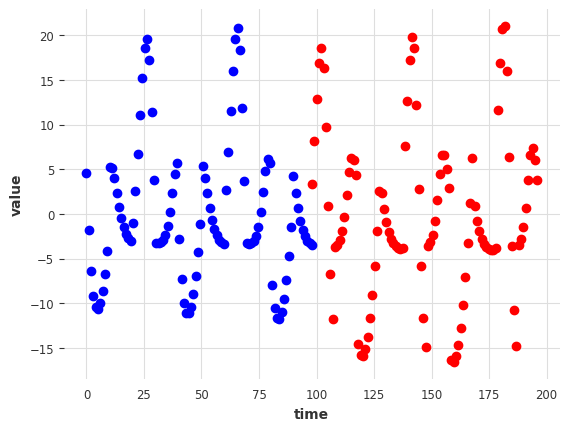

In [273]:
# Example usage:
concatenated_array_train = concatenate_arrays(highsample_train[1:50, 1] - np.mean(highsample_train[1:50, 1]), highsample_train[1:50, 2]-np.mean(highsample_train[1:50, 2]), 10)
concatenated_array_test = concatenate_arrays(highsample_test[1:50, 1] - np.mean(highsample_test[1:50, 1]) , highsample_test[1:50, 2]- np.mean(highsample_test[1:50, 2]), 10)
plt.plot(np.linspace(0,98,98),concatenated_array_train,'bo')
plt.plot(np.linspace(98,196,98),concatenated_array_test,'ro')
plt.xlabel('time')
plt.ylabel('value')

In [144]:
concatenated_array_test.shape

(98,)

In [147]:
concatenated_array = get_autotuned_predictions_data(concatenated_array_train, concatenated_array_test, hypers, num_samples, model_predict_fns['LLMTime GPT-4'], verbose=False, parallel=False)


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


100%|█████████████████████████████████████████████| 1/1 [00:22<00:00, 22.39s/it]

Text(0, 0.5, 'value')

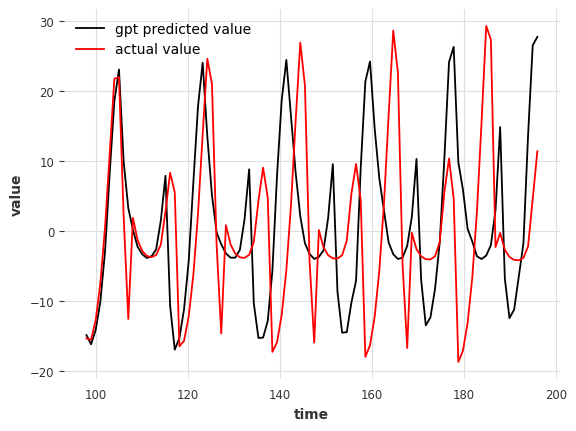

In [154]:
plt.plot(np.linspace(98,196,98),concatenated_array['median'])
plt.plot(np.linspace(98,196,98),concatenated_array_test,'-r')
plt.legend(['gpt predicted value','actual value'])
plt.xlabel('time')
plt.ylabel('value')

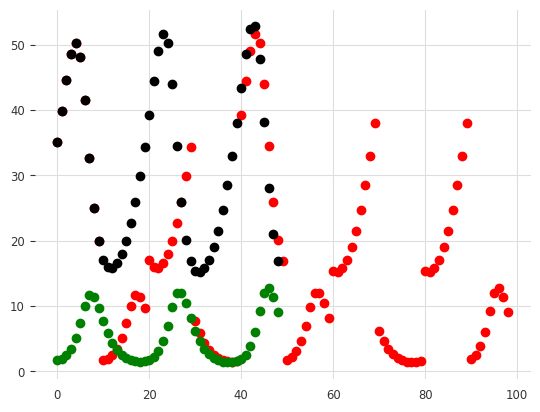

In [271]:
import numpy as np
import matplotlib.pyplot as plt

def concatenate_arrays_end2end(x_values, y_values, n):
    """
    Concatenate x_values and y_values into a single array, alternating between n points from each.

    Parameters:
    x_values: numpy array, first set of values
    y_values: numpy array, second set of values
    n: int, number of points to take at a time from each array

    Returns:
    concatenated_array: numpy array, concatenated array
    """
    x_values_copy = x_values.copy()  # Make a copy of x_values
    y_values_copy = y_values.copy()  # Make a copy of y_values

    concatenated_array = np.empty((0,))
    for i in range(0, len(x_values_copy)-n, n):
        y_values_copy[i:i+n] = y_values_copy[i:i+n] # - (y_values_copy[i] - x_values_copy[i+n-1])
        concatenated_array = np.concatenate((concatenated_array, x_values_copy[i:i+n], y_values_copy[i:i+n]))
        x_values_copy[i+n:i+2*n] = x_values_copy[i+n:i+2*n] # -  (x_values_copy[i+n] - y_values_copy[i+n-1])

    # Manually handle the last segment
    
    #y_values_copy[i:i+n] = y_values_copy[i:i+n]  - (y_values_copy[i] - x_values_copy[i+n-1])
    y_values_copy[i+n:i+2*n] = y_values_copy[i+n:i+2*n]  #- (y_values_copy[i+n] - x_values_copy[i+n-1])

    
    concatenated_array = np.concatenate((concatenated_array, x_values_copy[i:i+n], y_values_copy[i+n:i+2*n]))

    return concatenated_array

# Example usage
end2end_train = concatenate_arrays_end2end(highsample_train[1:50, 1], highsample_train[1:50, 2], 10)
end2end_test = concatenate_arrays_end2end(highsample_test[1:50, 1], highsample_test[1:50, 2], 10)
#plt.plot(end2end_train, 'bo')
plt.plot(end2end_test, 'ro')
plt.plot(highsample_test[1:50, 1], 'ko')
plt.plot(highsample_test[1:50, 2], 'go')
plt.show()


In [264]:
concat_gpt = get_autotuned_predictions_data(end2end_train, end2end_test, hypers, num_samples, model_predict_fns['LLMTime GPT-4'], verbose=False, parallel=False)


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


100%|█████████████████████████████████████████████| 1/1 [00:19<00:00, 19.79s/it]

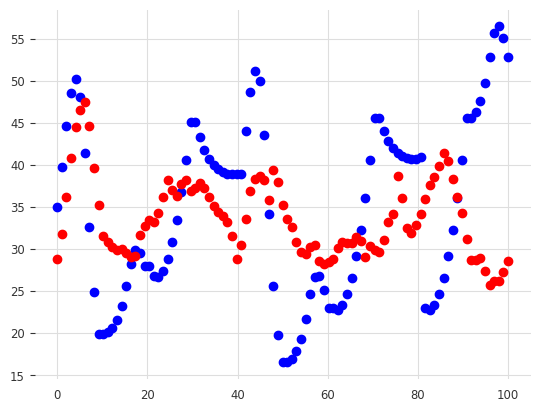

In [269]:
plt.plot(np.linspace(0,100,99),end2end_test,'bo')
plt.plot(np.linspace(0,100,99),concat_gpt['median']+20,'ro')

In [274]:
concat_aroundmean_gpt = get_autotuned_predictions_data(concatenated_array_train, concatenated_array_test, hypers, num_samples, model_predict_fns['LLMTime GPT-4'], verbose=False, parallel=False)


Sampling with best hyper... defaultdict(<class 'dict'>, {'model': 'gpt-4', 'alpha': 0.3, 'basic': True, 'temp': 1.0, 'top_p': 0.8, 'settings': SerializerSettings(base=10, prec=3, signed=True, fixed_length=False, max_val=10000000.0, time_sep=', ', bit_sep='', plus_sign='', minus_sign='-', half_bin_correction=True, decimal_point='', missing_str=' Nan')}) 
 with NLL inf


100%|█████████████████████████████████████████████| 1/1 [00:17<00:00, 17.46s/it]

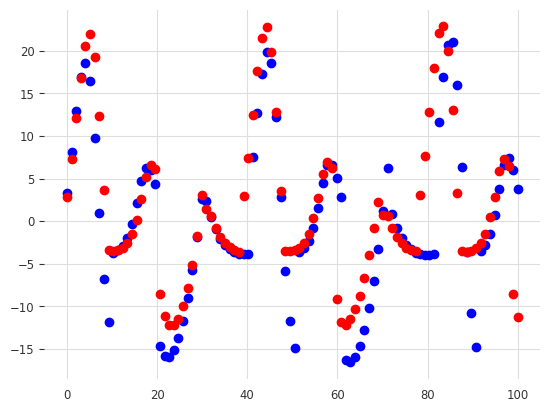

In [279]:
plt.plot(np.linspace(0,100,98),concatenated_array_test,'bo')
plt.plot(np.linspace(0,100,98),concat_aroundmean_gpt['median'],'ro')

In [233]:
highsample = np.genfromtxt('./synthetic_data/highsample4.csv', delimiter=',')
highsample_train = highsample[0:50]
highsample_test = highsample[50:100]



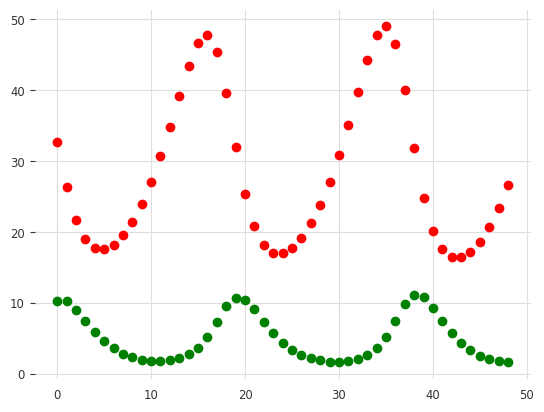

In [234]:
plt.plot(highsample_train[1:50, 1],'ro')
plt.plot(highsample_train[1:50, 2],'go')

In [248]:
highsample_train[1:50, 1]

array([32.74466474, 26.34880519, 21.76118865, 19.0341152 , 17.76562414,
       17.57515665, 18.2129752 , 19.53895343, 21.48361185, 24.01660892,
       27.12111605, 30.76669456, 34.87081306, 39.23533064, 43.4416322 ,
       46.70663746, 47.80953008, 45.47167648, 39.56765954, 32.02545061,
       25.38999441, 20.83483801, 18.2381473 , 17.10738448, 17.03708491,
       17.7782116 , 19.19813114, 21.23591765, 23.86984035, 27.09203786,
       30.88177427, 35.16657854, 39.75588424, 44.22658172, 47.75461852,
       49.00148622, 46.49995154, 40.06364703, 31.90214892, 24.87987101,
       20.18874829, 17.58391964, 16.48608737, 16.45464561, 17.23119388,
       18.68358587, 20.75519461, 23.4308703 , 26.71193596])